In [1]:
import numpy as np
import pandas as pd

import json

### Loading data

In [2]:
with open('data/machine_learning.json', 'r') as f:
    projects = json.load(f)

In [3]:
len(projects)

863

In [4]:
data = []
for project in projects:
    base = [project['id'], project['title'], project['description'], project['budget']['minimum'],
            project['budget']['maximum'], project['time_submitted']]
    
    project_bids = []
        
    for bid in project['bids']:
        row = [*base]
        
        reputation = bid['reputation']['entire_history']['category_ratings']
        
#         quality": 5.0,
#             "communication": 5.0,
#             "expertise": 5.0,
#             "professionalism": 5.0,
#             "hire_again
        row += [bid['score'], bid['highlighted'], bid['sealed'], bid['description'], bid['time_submitted'], 
                bid['amount'], bid['period'], reputation['quality'], reputation['communication'], 
                reputation['professionalism'], bid['award_status'] == 'awarded']
        
        project_bids.append(row)
        
    if [bid for bid in project_bids if bid[-1]]: # checking if there is awarded bid, if not skip
        data+=project_bids

In [5]:
data_columns = ['project_id', 'project_title', 'project_description', 'project_min_amount',
                'project_max_amount', 'project_time_submitted', 'bid_score', 'bid_highlighted', 'bid_sealed',
                'bid_description', 'bid_time_submitted', 'bid_amount', 'bid_period', 'bid_quality', 
                'bid_communication', 'bid_professionalism', 'bid_award_status']
data = pd.DataFrame(columns=data_columns, data=data)

In [6]:
data.describe()

,project_id,project_min_amount,project_max_amount,project_time_submitted,bid_score,bid_time_submitted,bid_amount,bid_period,bid_quality,bid_communication,bid_professionalism
count,9.557000e+03,9557.000000,9557.000000,9.557000e+03,9557.000000,9.557000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000
mean,3.405405e+07,382.678874,1529.513760,1.656576e+09,1.117307,1.656589e+09,998.448533,5.344460,4.030914,4.038101,4.034074
std,8.963263e+05,2038.137641,5941.043069,9.331853e+06,5.763419,9.331402e+06,4567.718632,15.226042,1.817168,1.819760,1.820191
min,3.250751e+07,8.000000,12.000000,1.640887e+09,0.396905,1.640888e+09,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.333857e+07,10.000000,30.000000,1.648574e+09,0.671246,1.648583e+09,20.000000,2.000000,4.477253,4.474072,4.461725
50%,3.396145e+07,30.000000,250.000000,1.655875e+09,0.737846,1.655876e+09,100.000000,5.000000,4.907784,4.919204,4.921129
75%,3.483296e+07,50.000000,250.000000,1.664823e+09,0.848181,1.664823e+09,250.000000,7.000000,5.000000,5.000000,5.000000
max,3.718741e+07,37500.000000,75000.000000,1.694663e+09,99.000000,1.694711e+09,150000.000000,999.000000,5.000000,5.000000,5.000000


In [7]:
sum(abs(data['bid_quality'] - data['bid_communication'])) / len(data)

0.053743435231163435

bid_quality and bid_communication are very similar, but in the same time, each of them have the difference which can have the impact on the final choosen bid

In [8]:
len(data['project_id'].unique()) - sum(data['bid_award_status'])

-38

In [9]:
sum(data.duplicated()), sum(data['project_id'].duplicated())

(0, 8787)

### Looking at boolean properties of bids

In [10]:
print('Bids len:', len(data))
sum(data['bid_award_status']) / len(data) * 100, '%'

Bids len: 9557


(8.45453594224129, '%')

In [11]:
print('Len of highlighted bids:', sum(data['bid_highlighted']))
sum(data.loc[data['bid_highlighted']]['bid_award_status']) / sum(data['bid_highlighted']) * 100, '%'

Len of highlighted bids: 22


(36.36363636363637, '%')

In [12]:
print('Len of sealed bids:', sum(data['bid_sealed']))
sum(data.loc[data['bid_sealed']]['bid_award_status']) / sum(data['bid_sealed']) * 100, '%'

Len of sealed bids: 1316


(10.638297872340425, '%')

In [13]:
data = data.drop(['bid_highlighted'], axis=1)

highlighted is negligible because of the a very little amount of such bids compared to all others, while sealed can play a little role

### Adding features

In [14]:
data['project/bid_amount_proportion'] = data['bid_amount'] / data['project_min_amount']
data = data.drop(['bid_amount', 'project_min_amount', 'project_max_amount'], axis=1)

In [15]:
# default bid period = 7days
data['bid_delay'] = (data['bid_time_submitted'] - data['project_time_submitted']) / (3600*24*7) 
data = data.drop(['project_time_submitted', 'bid_time_submitted'], axis=1)

### Transform text data in features

In [16]:
proportions = []

projects_titles_words = data['project_title'].apply(lambda x: x.split() if x else []).apply(set)
bid_descrs_words = data['bid_description'].apply(lambda x: x.split() if x else []).apply(set)

for project_title_set, bid_descr_set in zip(projects_titles_words, bid_descrs_words):
    words_checked = [word in bid_descr_set for word in project_title_set]
    proportions.append(sum(words_checked) / len(words_checked))
    
data['same_words_title/bid_proportion'] = proportions

In [17]:
proportions = []

projects_descrs_words = data['project_description'].apply(lambda x: x.split() if x else []).apply(set)
bid_descrs_words = data['bid_description'].apply(lambda x: x.split() if x else []).apply(set)

for project_descr_set, bid_descr_set in zip(projects_descrs_words, bid_descrs_words):
    words_checked = [word in bid_descr_set for word in project_descr_set]
    proportions.append(sum(words_checked) / len(words_checked))
    
data['same_words_descr/bid_proportion'] = proportions

In [18]:
data['bid_descr_len'] = data['bid_description'].apply(lambda x: len(x.split()) if x else 0)

In [19]:
proj_descr_len = data['project_description'].apply(lambda x: len(x.split()) if x else 0)

In [20]:
data['proj/bid_lens_proportion'] = data['bid_descr_len'] / proj_descr_len

In [21]:
greetings = ['good afternoon', 'good morning', 'how are you', 'how do you do', 'dear sir',
             'good night', 'hi', 'hello', 'pleased to meet you']

data['bid_greetings'] = data['bid_description'].apply(lambda x: x.lower() if x else '').apply(
    lambda x: any([x.find(greeting) != -1  for greeting in greetings]))

In [22]:
len(data) - sum(data['bid_greetings']) # without greeting

2092

### Look at correlations with new added features

In [23]:
data = data.drop(['project_title', 'project_description', 'bid_description'], axis=1)

In [24]:
corr_matrix = data.corr()
corr_matrix["bid_award_status"].abs().sort_values(ascending=False)

bid_award_status                   1.000000
bid_communication                  0.119845
bid_professionalism                0.118945
bid_quality                        0.118228
bid_score                          0.091682
project/bid_amount_proportion      0.066815
bid_delay                          0.062646
bid_descr_len                      0.039891
bid_sealed                         0.031368
bid_greetings                      0.031045
same_words_title/bid_proportion    0.021741
same_words_descr/bid_proportion    0.018940
project_id                         0.018423
bid_period                         0.015225
proj/bid_lens_proportion           0.014532
Name: bid_award_status, dtype: float64

### Adding categorical features

cut function generate bins with equal sizes

In [25]:
data['bin_quality'] = pd.cut(data['bid_quality'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

In [26]:
data['bid_communication'] = pd.cut(data['bid_communication'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

In [27]:
data['bid_professionalism'] = pd.cut(data['bid_professionalism'], bins=2, 
                             labels=False, include_lowest=True).astype( bool )

### Looking at linear dependencies

In [28]:
min(data['bid_score']), max(data['bid_score'])

(0.39690506293117, 99.0)

In [29]:
sum(data['bid_score'] > 50.)

33

In [30]:
data = data.drop(np.where(data['bid_score'] > 50.)[0], axis=0).reset_index(drop=True)

In [31]:
import matplotlib.pyplot as plt

def take_proportion_importance(prop_name):

    score_mean = np.mean(data[prop_name])

    big_score = data[prop_name] >= score_mean
    bid_score_percents = sum(data.loc[big_score]['bid_award_status']) / sum(big_score) * 100

    little_score = data[prop_name] < score_mean
    little_score_percents = sum(data.loc[little_score]['bid_award_status']) / sum(little_score) * 100

    print((bid_score_percents, sum(big_score)), (little_score_percents, sum(little_score)))

bid_score also doesn't influence a lot on awardness of the bid

(8.796930665935873, 3649) (8.0, 5875)


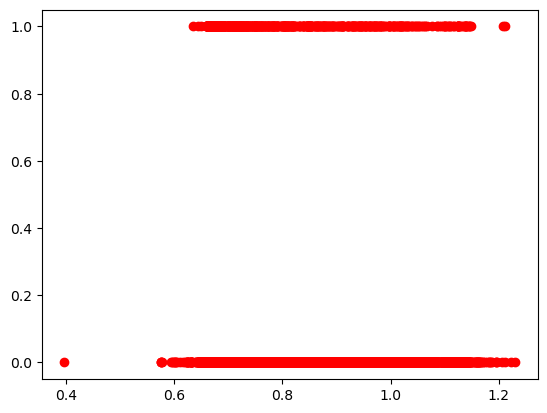

In [32]:
take_proportion_importance('bid_score')
plt.plot(data['bid_score'], data['bid_award_status'], 'ro')

(4.1679250981576565, 3311) (10.51022050539192, 6213)


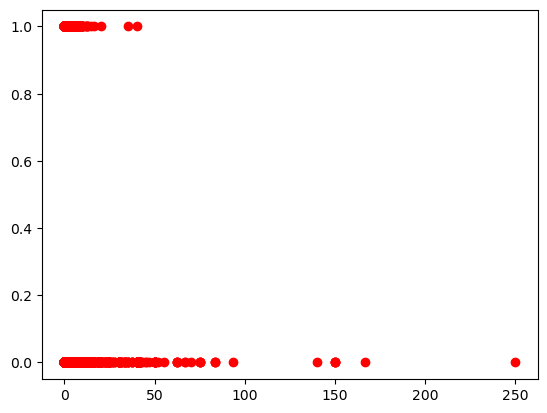

In [33]:
take_proportion_importance('project/bid_amount_proportion')
plt.plot(data['project/bid_amount_proportion'], data['bid_award_status'], 'ro')

In [34]:
take_proportion_importance('bid_delay')

(10.170293282876063, 2114) (7.773279352226721, 7410)


### prepare data

bid_score


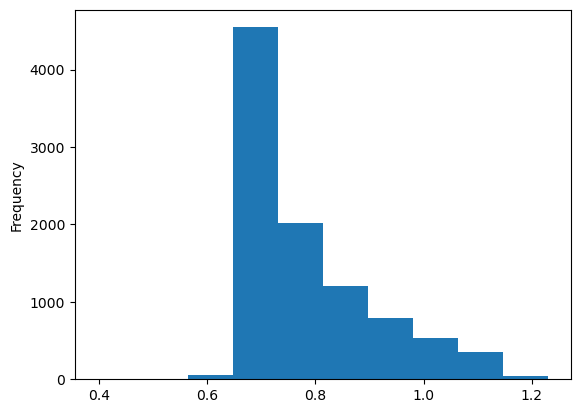

bid_period


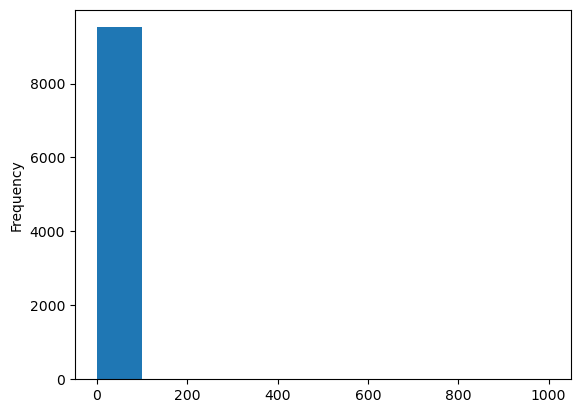

bid_quality


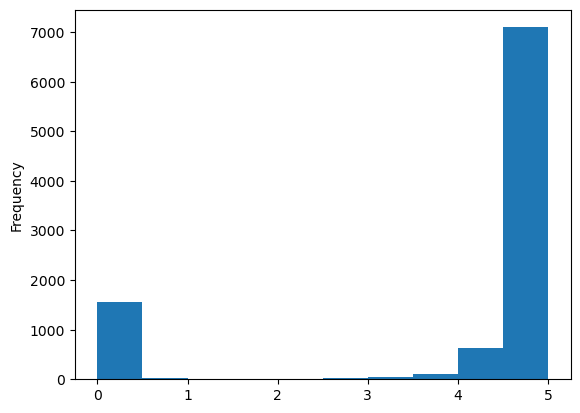

project/bid_amount_proportion


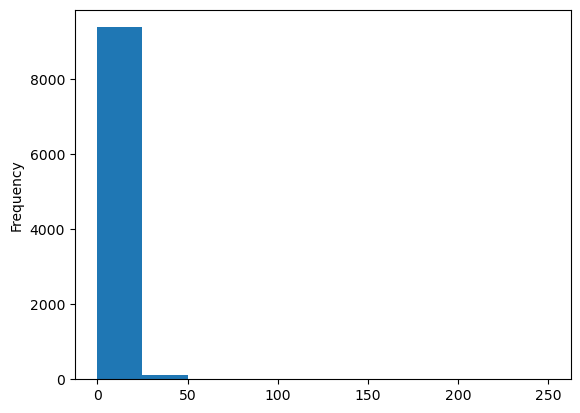

bid_delay


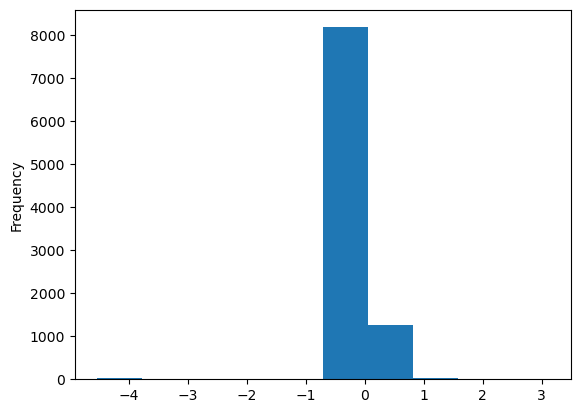

same_words_title/bid_proportion


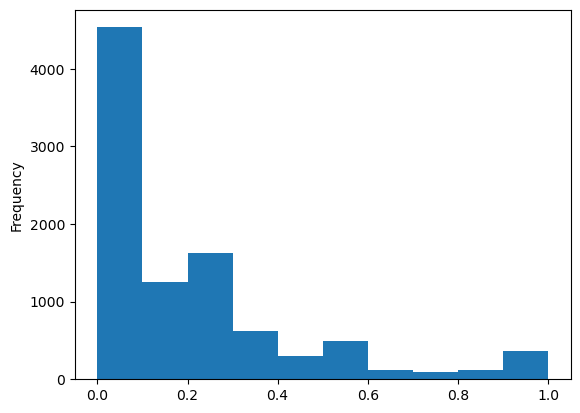

same_words_descr/bid_proportion


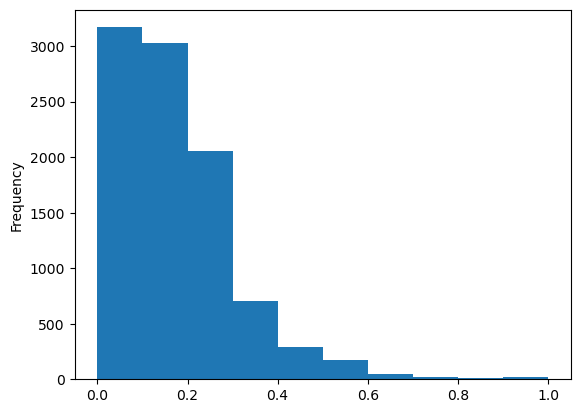

bid_descr_len


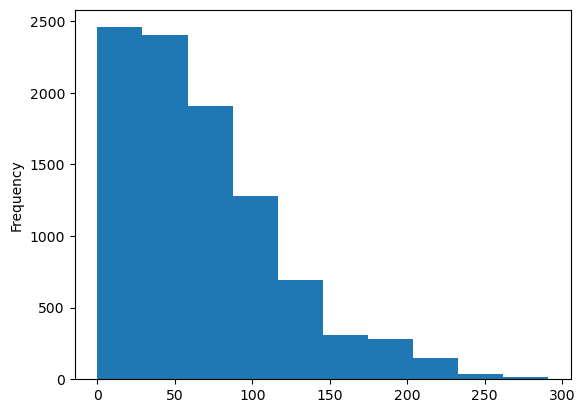

proj/bid_lens_proportion


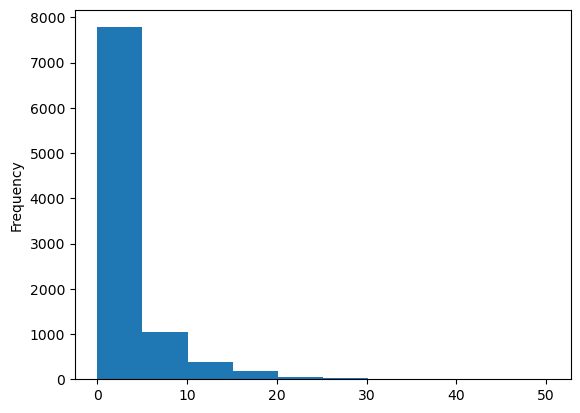

In [35]:
for column in data.select_dtypes(include=['number']).columns:
    if column in ['project_id']: continue
        
#     plt.figure(figsize=(10,2))
    print(column)
    data[column].plot.hist()
    plt.show()

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=.2)

X = data.drop(['project_id', 'bid_award_status'], axis=1)
project_ids = data['project_id'].values

X_num, X_cat = X.select_dtypes(include=['number']).values, X.select_dtypes(exclude=['number']).values

y = data['bid_award_status'].to_numpy()

for train_index, test_index in sss.split(X,y):
    X_train_num, X_test_num  = X_num[train_index], X_num[test_index]
    X_train_cat, X_test_cat = X_cat[train_index], X_cat[test_index]
    
    y_train, y_test = y[train_index], y[test_index]
    
    project_ids = np.append(project_ids[train_index], project_ids[test_index])

In [37]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [38]:
X_train, X_test = np.c_[X_train_num, X_train_cat], np.c_[X_test_num, X_test_cat]

In [39]:
# for train_index, val_index in sss.split(X_train, y_train):
#     X_val, y_val = X_train[val_index], y_train[val_index]
#     X_train, y_train = X_train[train_index], y_train[train_index]

### Algorithms checking

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC

from functools import partial

from sklearn.metrics import accuracy_score, precision_score, recall_score

def get_metrics(y,pred):
    for metric in [accuracy_score, precision_score, recall_score]:
        if metric.__name__ == 'accuracy_score':
            result = metric(y, pred)
        else:
            result = metric(y, pred, zero_division=0)
        print(metric.__name__[:-6], f'{round(result*100,2)}%')

trained_models = [] # for future hard voting

models = [partial(LogisticRegression, max_iter=10_000), RandomForestClassifier, GradientBoostingClassifier, 
          SVC, partial(LinearSVC, max_iter=10_000), KNeighborsClassifier, GaussianNB]
for model in models:
        
    try:
        model = model(class_weight='balanced')
    except:
        model = model()
    
    print(type(model).__name__)
        
    model.fit(X_train, y_train)
    trained_models.append(model)
    
    pred = model.predict(X_test)
    
    get_metrics(y_test,pred)
        
    print()

LogisticRegression
accuracy 51.29%
precision 12.18%
recall 78.48%

RandomForestClassifier
accuracy 91.55%
precision 28.57%
recall 1.27%

GradientBoostingClassifier
accuracy 91.76%
precision 52.94%
recall 5.7%

SVC
accuracy 58.64%
precision 14.29%
recall 79.75%

LinearSVC


/home/hacker/_sources/_apps/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy 49.87%
precision 12.23%
recall 81.65%

KNeighborsClassifier
accuracy 91.02%
precision 24.0%
recall 3.8%

GaussianNB
accuracy 32.6%
precision 10.18%
recall 91.14%



- for precision: the best is Gradient Boosting. With this model, only for 2 of 20 project will be given result, but one of two of such prediction will be correct

- for recall: the best is Gaussian Naive Bayes. In the predictions of such model, it will be appear 90% of awarded bids, but only 10% of all positive predictions will be correct

### Looking at correct predictions of the winner

In [ ]:
X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test, axis=0)

def get_accuracies(y,pred):
    top_accuracy, top_2_accuracy = [],[]
    for project_id in set(project_ids):
        indexes = project_ids == project_id
        
        if sum(indexes) < 10: continue
        projects_n+=1
        
        y_project,pred_project = y[indexes], pred[indexes]
        
        # choosing the best bid (along predictions)
        top_accuracy.append( y_project[np.argmax(pred_project)] )
        
        # choosing the top 2 best bids (along predictions)
        sorted_pred = np.argsort(pred_project)[:-2 -1:-1]
        top_2_accuracy.append( any(y_project[ sorted_pred ]) )
        
    top_accuracy = np.mean(top_accuracy) * 100
    top_2_accuracy = np.mean(top_2_accuracy) * 100

    return top_accuracy, top_2_accuracy

In [81]:
for model in trained_models:
    pred = model.predict(X)
    
    top_accuracy, top_2_accuracy = get_accuracies(y, pred)
    
    print('model name: {}, top accuracy: {:.2f}%, top 2 accuracy: {:.2f}%'.format(
        type(model).__name__,top_accuracy,top_2_accuracy))
    
print('Projects test number', len(set(project_ids)))

model name: LogisticRegression, top accuracy: 12.89%, top 2 accuracy: 23.28%
model name: RandomForestClassifier, top accuracy: 80.46%, top 2 accuracy: 88.36%
model name: GradientBoostingClassifier, top accuracy: 12.68%, top 2 accuracy: 17.67%
model name: SVC, top accuracy: 14.97%, top 2 accuracy: 26.20%
model name: LinearSVC, top accuracy: 13.10%, top 2 accuracy: 21.62%
model name: KNeighborsClassifier, top accuracy: 16.22%, top 2 accuracy: 20.79%
model name: GaussianNB, top accuracy: 10.19%, top 2 accuracy: 18.30%
Projects test number 481


- as conclusion for entire project, the best model is Random Forest. So for each project the model will predict correctly the awarded bin, with 80% probability, or 88% if to look at the first and second biggest probabilities

### Further training of  models (SVC - Support Vector Classification)

In [337]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svc = SVC(class_weight='balanced')

params_distributions = {"gamma": reciprocal(.0001, 0.5), "C": uniform(1,15)}
rnd_search_cv = RandomizedSearchCV(svc, params_distributions, n_iter=10, verbose=2, cv=3, scoring='f1')
rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END .....C=2.9795712456729833, gamma=0.0022469075884805; total time=   1.6s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ....C=12.513403566980532, gamma=0.02955194223498697; total time=   1.5s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.9s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.9s
[CV] END ...C=3.524400448502831, gamma=0.0002197222920863366; total time=   1.8s
[CV] END ...C=10.761106844109145, gamma=0.011009214500460713; total time=   1.5s
[CV] END ...C=10.761106844109145, gamma=0.011009214500460713; total time=   1.8s
[CV] END ...C=10.761106844109145, gamma=0.011009

RandomizedSearchCV(cv=3, estimator=SVC(class_weight='balanced'),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe6ec333790>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe6d3099af0>},
                   scoring='f1', verbose=2)

In [338]:
round(rnd_search_cv.best_score_*100,2)

18.34

In [339]:
best_estimator = rnd_search_cv.best_estimator_
best_estimator

SVC(C=7.3308049907478745, class_weight='balanced', gamma=0.045798151396616624)

In [340]:
pred = best_estimator.predict(X_test)
get_metrics(y_test,pred)

accuracy 56.58%
precision 9.96%
recall 71.72%


### Further training RandomForests

In [341]:
from sklearn.model_selection import GridSearchCV

svc = RandomForestClassifier(class_weight='balanced')

params_grid = [{"n_estimators": [5,20,100], "max_features": [2,4]},
               {"min_samples_leaf": [2,4], "max_depth": [2,3]}]

grid_search_cv = RandomizedSearchCV(svc, params_grid, n_iter=10, verbose=2, cv=3, scoring='recall')
grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=2, n_estimators=5; total time=   0.1s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ....................max_features=2, n_estimators=20; total time=   0.2s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END ...................max_features=2, n_estimators=100; total time=   0.8s
[CV] END .....................max_features=4, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=4, n_estimators=5; total time=   0.1s
[CV] END .....................max_features=4, n_

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   param_distributions=[{'max_features': [2, 4],
                                         'n_estimators': [5, 20, 100]},
                                        {'max_depth': [2, 3],
                                         'min_samples_leaf': [2, 4]}],
                   scoring='recall', verbose=2)

In [342]:
best_estimator = grid_search_cv.best_estimator_
best_estimator

RandomForestClassifier(class_weight='balanced', max_depth=2, min_samples_leaf=2)

In [343]:
pred = best_estimator.predict(X_test)
get_metrics(y_test,pred)

accuracy 44.98%
precision 8.88%
recall 81.82%


### Hard voting

In [64]:
from sklearn.ensemble import VotingClassifier

vot_clf = VotingClassifier([(type(model).__name__, model) for model in trained_models],
                           voting='hard')
vot_clf.fit(X_train, y_train)

pred = vot_clf.predict(X_test)
get_metrics(y_test, pred)

/home/hacker/_sources/_apps/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


accuracy 62.78%
precision 14.81%
recall 73.42%
